In [1]:
import numpy as np
import torch
import os
import skimage.io as io
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch import from_numpy as from_numpy
from matplotlib.colors import ListedColormap

from func.model_arch2 import SegAirwayModel

/home/wangc/anaconda3/envs/test1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###     数据，这些数据是已经被裁剪过的3d patch

In [2]:
Precrop_dataset_for_train_path = "/mnt/wangc/EXACT09/Precrop_dataset_for_EXACT091"
Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"

raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
print(len(raw_case_name_list))
# raw_case_name_list = os.listdir(Precrop_dataset_for_train_label_path)

#二次聚类

# Precrop_dataset_for_train_path = "/mnt/share102/cs22-wangc/EXACT09/Cluster/class0"
# Precrop_dataset_for_train_raw_path = Precrop_dataset_for_train_path+"/image"
# Precrop_dataset_for_train_label_path = Precrop_dataset_for_train_path+"/label"

# raw_case_name_list = os.listdir(Precrop_dataset_for_train_raw_path)
# # raw_case_name_list = os.listdir(Precrop_dataset_for_train_label_path)

8832


### 需要对数据进行进一步变化

In [3]:

class Random3DCrop_np(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)), 'Attention: random 3D crop output size: an int or a tuple (length:3)'
        if isinstance(output_size, int):
            self.output_size=(output_size, output_size, output_size)
        else:
            assert len(output_size)==3, 'Attention: random 3D crop output size: a tuple (length:3)'
            self.output_size=output_size
        
    def random_crop_start_point(self, input_size):
        assert len(input_size)==3, 'Attention: random 3D crop output size: a tuple (length:3)'
        d, h, w=input_size
        d_new, h_new, w_new=self.output_size
        
        d_new = min(d, d_new)
        h_new = min(h, h_new)
        w_new = min(w, w_new)
        
        assert (d>=d_new and h>=h_new and w>=w_new), "Attention: input size should >= crop size; now, input_size is "+str((d,h,w))+", while output_size is "+str((d_new, h_new, w_new))
        
        d_start=np.random.randint(0, d-d_new+1)
        h_start=np.random.randint(0, h-h_new+1)
        w_start=np.random.randint(0, w-w_new+1)
        
        return d_start, h_start, w_start
    
    def __call__(self, img_3d, start_points=None):
        img_3d=np.array(img_3d)
        
        d, h, w=img_3d.shape
        d_new, h_new, w_new=self.output_size
        
        if start_points == None:
            start_points = self.random_crop_start_point(img_3d.shape)
        
        d_start, h_start, w_start = start_points
        d_end = min(d_start+d_new, d)
        h_end = min(h_start+h_new, h)
        w_end = min(w_start+w_new, w)
        
        crop=img_3d[d_start:d_end, h_start:h_end, w_start:w_end]
        
        return crop

class Normalization_np(object):
    def __init__(self, windowMin, windowMax):
        self.name = 'ManualNormalization'
        assert isinstance(windowMax, (int,float))
        assert isinstance(windowMin, (int,float))
        self.windowMax = windowMax
        self.windowMin = windowMin
    
    def __call__(self, img_3d):
        img_3d_norm = np.clip(img_3d, self.windowMin, self.windowMax)
        img_3d_norm-=np.min(img_3d_norm)
        max_99_val=np.percentile(img_3d_norm, 99)
        if max_99_val>0:
            img_3d_norm = img_3d_norm/max_99_val*255
        return img_3d_norm
crop_size = (32, 128, 128)
windowMin=-1000
windowMax=150
random3dcrop=Random3DCrop_np(crop_size)
normalization=Normalization_np(windowMin, windowMax)

### 设置device、model、权重

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model=SegAirwayModel(in_channels=1, out_channels=2)
model.to(device)
load_pkl='/home/wangc/now/NaviAirway/checkpoint/abc_checkpoint_sample_org_33.pkl'
checkpoint = torch.load(load_pkl)
model.load_state_dict(checkpoint['model_state_dict'])
print(load_pkl)

/home/wangc/now/NaviAirway/checkpoint/abc_checkpoint_sample_org_33.pkl


### 需要调整样本数量就修改下面的N即可

In [4]:
N = 10000
N=min(N,len(raw_case_name_list))
N

8832

### 使用embedding网络进行encode

In [6]:
# i = 0
# embeddings_list = []  # 用于存储每个图像的 embeddings[3]
# embeddings_dict = {}
# for name in raw_case_name_list:
#     if i < N:
#         i += 1
#         img_addr = Precrop_dataset_for_train_raw_path+ "/" + name
#         label_addr=Precrop_dataset_for_train_label_path + "/" + name
#         print(f'this is {i}')
#         img = io.imread(img_addr, plugin='simpleitk')
#         label_img=io.imread(label_addr, plugin='simpleitk')

#         start_points = random3dcrop.random_crop_start_point(img.shape)  # 起点
#         raw_img_crop = random3dcrop(np.array(img, float), start_points=start_points)
#         raw_img_crop = normalization(raw_img_crop)
#         raw_img_crop = np.expand_dims(raw_img_crop, axis=0)




#         if 1 in label_img:
#             b = from_numpy(raw_img_crop).float()
#             b = b.unsqueeze(0).to(device)
#             embeddings = model.get_embedding(b)
#             emb3=embeddings[3].cpu().detach().numpy()
#             embeddings_list.append(emb3)  # 移动到CPU并转为NumPy后添加到列表
#             embeddings_dict[name] = emb3
#             del b

# # 将列表中的NumPy数组堆叠成一个NumPy数组
# stacked_embeddings_numpy = np.stack(embeddings_list, axis=0)
# N=min(N,len(embeddings_list))
# print(stacked_embeddings_numpy.shape)  # 输出应为 [N, 256, 4, 16, 16]

from active_learning_with_exact09 import process_images
embeddings_list, embeddings_dict=process_images(Precrop_dataset_for_train_path,raw_case_name_list, N, model, device,
                                                only_positive=False
                                                )
# 将列表中的NumPy数组堆叠成一个NumPy数组
stacked_embeddings_numpy = np.stack(embeddings_list, axis=0)
print(stacked_embeddings_numpy.shape)  # 输出应为 [N, 256, 4, 16, 16]



this is 1
this is 2
this is 3
this is 4
this is 5
this is 6
this is 7
this is 8
this is 9
this is 10
this is 11
this is 12
this is 13
this is 14
this is 15
this is 16
this is 17
this is 18
this is 19
this is 20
this is 21
this is 22
this is 23
this is 24
this is 25
this is 26
this is 27
this is 28
this is 29
this is 30
this is 31
this is 32
this is 33
this is 34
this is 35
this is 36
this is 37
this is 38
this is 39
this is 40
this is 41
this is 42
this is 43
this is 44
this is 45
this is 46
this is 47
this is 48
this is 49
this is 50
this is 51
this is 52
this is 53
this is 54
this is 55
this is 56
this is 57
this is 58
this is 59
this is 60
this is 61
this is 62
this is 63
this is 64
this is 65
this is 66
this is 67
this is 68
this is 69
this is 70
this is 71
this is 72
this is 73
this is 74
this is 75
this is 76
this is 77
this is 78
this is 79
this is 80
this is 81
this is 82
this is 83
this is 84
this is 85
this is 86
this is 87
this is 88
this is 89
this is 90
this is 91
this is 

In [16]:
type(embeddings_list[1])

numpy.ndarray

In [7]:
#要保存使用这个代码
import os
import numpy as np
import pickle

# 假设你有以下列表和字典


# 指定保存文件的完整路径
file_path = '/home/wangc/now/NaviAirway/saved_var/num_8832_embeddings_data.pkl'

# 确保文件夹存在，如果不存在则创建它
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存到文件
with open(file_path, 'wb') as file:
    data_to_save = {'embeddings_list': embeddings_list, 'embeddings_dict': embeddings_dict}
    pickle.dump(data_to_save, file)






In [8]:
from active_learning_with_exact09 import process_images
embeddings_list, embeddings_dict=process_images(Precrop_dataset_for_train_path,raw_case_name_list, N, model, device,
                                                only_positive=True
                                                )
# 将列表中的NumPy数组堆叠成一个NumPy数组
stacked_embeddings_numpy = np.stack(embeddings_list, axis=0)
print(stacked_embeddings_numpy.shape)  # 输出应为 [N, 256, 4, 16, 16]

file_path = '/home/wangc/now/NaviAirway/saved_var/num_8832_embeddings_data.pkl'

# 确保文件夹存在，如果不存在则创建它
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存到文件
with open(file_path, 'wb') as file:
    data_to_save = {'embeddings_list': embeddings_list, 'embeddings_dict': embeddings_dict}
    pickle.dump(data_to_save, file)

this is 1
this is 2
this is 3
this is 4
this is 5
this is 6
this is 7
this is 8
this is 9
this is 10
this is 11
this is 12
this is 13
this is 14
this is 15
this is 16
this is 17
this is 18
this is 19
this is 20
this is 21
this is 22
this is 23
this is 24
this is 25
this is 26
this is 27
this is 28
this is 29
this is 30
this is 31
this is 32
this is 33
this is 34
this is 35
this is 36
this is 37
this is 38
this is 39
this is 40
this is 41
this is 42
this is 43
this is 44
this is 45
this is 46
this is 47
this is 48
this is 49
this is 50
this is 51
this is 52
this is 53
this is 54
this is 55
this is 56
this is 57
this is 58
this is 59
this is 60
this is 61
this is 62
this is 63
this is 64
this is 65
this is 66
this is 67
this is 68
this is 69
this is 70
this is 71
this is 72
this is 73
this is 74
this is 75
this is 76
this is 77
this is 78
this is 79
this is 80
this is 81
this is 82
this is 83
this is 84
this is 85
this is 86
this is 87
this is 88
this is 89
this is 90
this is 91
this is 

In [10]:
# 从文件加载
file_path = '/home/wangc/now/NaviAirway/saved_var/only_positive_8832_embeddings_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存到文件
with open(file_path, 'wb') as file:
    data_to_save = {'embeddings_list': embeddings_list, 'embeddings_dict': embeddings_dict}
    pickle.dump(data_to_save, file)



In [7]:
embeddings_dict.keys()

dict_keys(['EXACT09_CASE01_0.nii.gz', 'EXACT09_CASE01_1.nii.gz', 'EXACT09_CASE01_2.nii.gz', 'EXACT09_CASE01_3.nii.gz', 'EXACT09_CASE01_4.nii.gz', 'EXACT09_CASE01_5.nii.gz', 'EXACT09_CASE01_6.nii.gz', 'EXACT09_CASE01_7.nii.gz', 'EXACT09_CASE01_8.nii.gz', 'EXACT09_CASE01_9.nii.gz', 'EXACT09_CASE01_10.nii.gz', 'EXACT09_CASE01_11.nii.gz', 'EXACT09_CASE01_12.nii.gz', 'EXACT09_CASE01_13.nii.gz', 'EXACT09_CASE01_14.nii.gz', 'EXACT09_CASE01_15.nii.gz', 'EXACT09_CASE01_16.nii.gz', 'EXACT09_CASE01_17.nii.gz', 'EXACT09_CASE01_18.nii.gz', 'EXACT09_CASE01_19.nii.gz', 'EXACT09_CASE01_20.nii.gz', 'EXACT09_CASE01_21.nii.gz', 'EXACT09_CASE01_22.nii.gz', 'EXACT09_CASE01_23.nii.gz', 'EXACT09_CASE01_24.nii.gz', 'EXACT09_CASE01_25.nii.gz', 'EXACT09_CASE01_26.nii.gz', 'EXACT09_CASE01_27.nii.gz', 'EXACT09_CASE01_28.nii.gz', 'EXACT09_CASE01_29.nii.gz', 'EXACT09_CASE01_30.nii.gz', 'EXACT09_CASE01_31.nii.gz', 'EXACT09_CASE01_32.nii.gz', 'EXACT09_CASE01_33.nii.gz', 'EXACT09_CASE01_34.nii.gz', 'EXACT09_CASE01_35.

### 和上面一样，这个是使用gpu加速的同一方法

In [32]:
#代码略
# 见/home/cs22-wangc/now/NaviAirway/active_learning_with_exact09.py

### 将stacked_embeddings_numpy转为torch张量并进行reshape

In [8]:
X = torch.from_numpy(stacked_embeddings_numpy)
N=X.shape[0]
X_t = X.reshape(N, -1)


In [9]:
X_t.shape

torch.Size([4000, 262144])

### 聚类 然后 Tsne

In [10]:
from sklearn.cluster import KMeans

# 对 X_t 进行 K-Means 聚类
num_clusters = 2#2
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X_t)

# 将聚类结果添加到 X_t 中作为最后一列
X_t_with_labels = np.column_stack((X_t, cluster_labels))



/home/wangc/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
X_t.shape, cluster_labels.shape

((1092, 262144), (1092,))

In [15]:
print(cluster_labels.shape,X_t_with_labels.shape)
print(cluster_labels)

(536,) (536, 262145)
[0 1 0 0 1 2 2 2 2 1 1 1 2 2 2 2 2 2 0 0 2 2 2 0 0 0 1 2 2 2 0 1 1 2 1 0 2
 0 2 0 0 2 2 2 2 2 1 2 2 0 2 0 0 2 0 0 1 2 0 1 1 2 2 2 0 1 0 0 2 0 2 2 0 0
 0 1 1 0 0 2 1 1 0 0 0 0 2 2 2 2 0 2 2 0 2 1 0 2 0 0 0 1 2 0 2 0 0 0 0 2 2
 0 2 2 0 0 2 0 2 1 2 0 0 1 0 2 2 2 2 2 0 2 1 2 2 1 1 0 2 0 2 0 0 1 2 2 2 2
 2 1 2 0 0 0 1 2 1 0 0 2 1 0 2 2 0 0 2 2 0 2 2 2 2 0 2 1 0 0 2 2 2 2 2 1 1
 2 1 2 1 1 0 1 2 0 0 2 2 0 1 2 2 2 0 0 0 1 0 2 2 0 0 2 2 2 2 2 1 2 2 2 0 2
 2 2 0 2 1 1 0 0 2 2 2 1 2 2 2 0 2 2 2 1 2 0 1 0 2 2 0 2 0 0 0 2 2 1 2 0 1
 2 0 2 0 2 2 0 0 2 1 2 2 2 0 2 2 0 2 2 2 0 2 0 2 2 0 0 1 0 0 2 1 1 0 1 1 0
 0 2 1 2 2 2 2 1 2 1 2 2 2 2 1 0 0 1 0 0 1 2 0 1 0 2 1 2 2 2 1 2 0 0 1 2 1
 2 2 1 0 1 0 1 1 0 2 0 1 1 0 2 1 2 2 0 1 0 0 2 2 2 0 2 2 0 0 2 1 0 2 0 0 1
 1 2 2 0 2 1 1 0 2 2 0 2 2 2 0 2 2 1 0 2 2 0 2 2 2 0 2 0 0 2 2 2 2 1 0 1 2
 0 1 2 0 2 0 1 2 0 1 2 1 0 1 1 2 2 2 2 2 1 2 2 2 0 0 2 0 2 1 2 0 2 2 2 2 0
 0 2 0 2 1 2 0 0 2 2 2 2 2 2 2 2 0 0 2 2 0 0 1 0 2 2 1 2 1 2 2 2 0 2 2 1 1
 1 2

### 2d Tsne

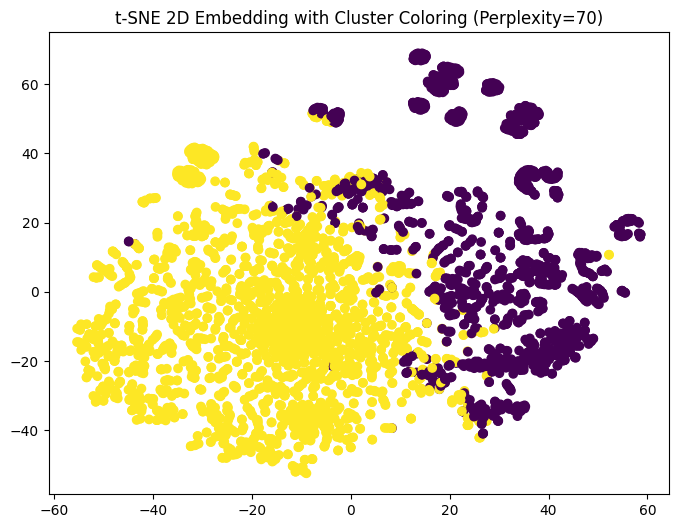

In [11]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# 使用 perplexity 为 50 的 t-SNE 进行嵌入
tsne = TSNE(n_components=2, perplexity=70)
X_embedded_2d = tsne.fit_transform(X_t_with_labels)
embedding_dict = {raw_case_name_list[i]: X_embedded_2d[i] for i in range(N)}


# 使用 t-SNE 进行降维
threshold_dim1 = 200  # 调整阈值
threshold_dim2 = 200  # 调整阈值

# 筛选出维度值在一定范围内的数据
filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]

# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]


# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
# colors = list(mcolors.TABLEAU_COLORS.values())
# custom_cmap = mcolors.ListedColormap(colors)


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

# 使用 ListedColormap 为不同的聚类簇指定颜色
custom_cmap = ListedColormap(colors)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")
# # 定义自定义的颜色映射

# sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=cluster_labels.min(), vmax=cluster_labels.max()))
# sm._A = []  # 设置一个空的数组
plt.show()


### 3d Tsne

In [ ]:
# 使用 t-SNE 进行降维
tsne = TSNE(n_components=3, perplexity=70, random_state=0)
X_embedded_3d = tsne.fit_transform(X_t)

unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

# 使用 ListedColormap 为不同的聚类簇指定颜色
custom_cmap = ListedColormap(colors)

# 可视化三维嵌入并根据聚类标签着色
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # 创建3D图的坐标轴对象

ax.scatter(X_embedded_3d[:, 0], X_embedded_3d[:, 1], X_embedded_3d[:, 2], c=cluster_labels, cmap=custom_cmap)
ax.set_title("t-SNE 3D Embedding with Cluster Coloring (Perplexity=70)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.colorbar()
plt.savefig('scatter_plot_3d_colored.png')
plt.show()



### 如果想索引对应的点，可以使用这里的代码

In [ ]:


from matplotlib.colors import ListedColormap


X_t=np.array(list(embeddings_dict.values())).reshape(N,-1)
kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(X_t)



tsne = TSNE(n_components=2, perplexity=70, random_state=0)
X_embedded_2d = tsne.fit_transform(X_t)

# 使用 t-SNE 进行降维
threshold_dim1 = 100  # 调整阈值
threshold_dim2 = 100  # 调整阈值

# 筛选出维度值在一定范围内的数据

filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < threshold_dim1) & (abs(X_embedded_2d[:, 1]) < threshold_dim2))[0]
# 筛选出符合阈值的数据
filtered_embeddings = X_embedded_2d[filtered_indices]

# 提取嵌入坐标和对应的名称
names = list(embeddings_dict.keys())

names_filtered = [names[i] for i in filtered_indices]


unique_labels = np.unique(cluster_labels)
cmap = plt.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]

# 使用 ListedColormap 为不同的聚类簇指定颜色
custom_cmap = ListedColormap(colors)

# 清除之前的图像，以防止重叠
plt.clf()

# 在每个点上标记对应的名称

# 绘制二维散点图，只绘制符合阈值的数据
# 可视化二维嵌入并根据聚类标签着色
plt.figure(figsize=(20, 16), dpi=100)
for i in range(len(filtered_indices)):
    # name = names_filtered[i]
    plt.annotate(i, (filtered_embeddings[i, 0], filtered_embeddings[i, 1]), fontsize=8, alpha=0.7)

plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=cluster_labels.min(), vmax=cluster_labels.max()))
sm._A = []  # 设置一个空的数组
# plt.show()


In [14]:
print(N)

2281


In [15]:


from matplotlib.colors import ListedColormap


X_t=np.array(list(embeddings_dict.values())).reshape(N,-1)
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(X_t)



tsne = TSNE(n_components=2, perplexity=70, random_state=0)
X_embedded_2d = tsne.fit_transform(X_t)





/home/cs22-wangc/anaconda3/envs/test1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def visualize_and_return_indices(X_embedded_2d, cluster_labels, embeddings_dict, x1=100,y1=100,
                                 x2=None,y2=None,selected_indices=None,show_index=False):



    if x2 is None and y2 is None:
        filtered_indices = np.where((abs(X_embedded_2d[:, 0]) < abs(x1)) & (abs(X_embedded_2d[:, 1]) < abs(y1)))[0]
    
    else:

        # 创建布尔索引
        x_condition = (X_embedded_2d[:, 0] >= x1) & (X_embedded_2d[:, 0] <= x2)
        y_condition = (X_embedded_2d[:, 1] >= y1) & (X_embedded_2d[:, 1] <= y2)#纵轴
    
        # 通过两个条件的逻辑与来筛选元素
        filtered_indices = np.where(x_condition & y_condition)[0]
    print('filtered_indices',len(filtered_indices))
    if selected_indices is not None:
        intersection_set = set(filtered_indices).intersection(selected_indices)
        filtered_indices = list(intersection_set)
        print('selected_indices',len(filtered_indices))
    # 筛选出符合阈值的数据
    filtered_embeddings = X_embedded_2d[filtered_indices]
    

    # 提取嵌入坐标和对应的名称
    names = list(embeddings_dict.keys())
    names_filtered = [names[i] for i in filtered_indices]
    unique_labels = np.unique(cluster_labels[filtered_indices])
    cmap = plt.get_cmap('viridis', len(unique_labels))
    colors = [cmap(i) for i in range(len(unique_labels))]
    custom_cmap = ListedColormap(colors)
    
    # 清除之前的图像，以防止重叠
    plt.clf()
    
    # 绘制图像
    plt.figure(figsize=(8, 6), dpi=100)
    if show_index is True:
        for i, j in enumerate(filtered_indices):
            plt.annotate(j, (filtered_embeddings[i, 0], filtered_embeddings[i, 1]), fontsize=8, alpha=0.7)
        # print(i)



    num_classes = len(unique_labels)
    random_colors = np.random.rand(num_classes, 3)
    custom_cmap = ListedColormap(random_colors)

    plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=cluster_labels[filtered_indices], cmap=custom_cmap)
    print('filtered_embeddings.shape',filtered_embeddings.shape)
    plt.title("t-SNE 2D Embedding with Cluster Coloring (Perplexity=70)")
    # sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=cluster_labels.min(), vmax=cluster_labels.max()))
    # sm._A = []  # 设置一个空的数组
    
    # 保存图片
    plt.savefig("visualization.png")
    
    # 返回结果
    return filtered_indices, names_filtered

filtered_indices 1092
filtered_embeddings.shape (1092, 2)


<Figure size 640x480 with 0 Axes>

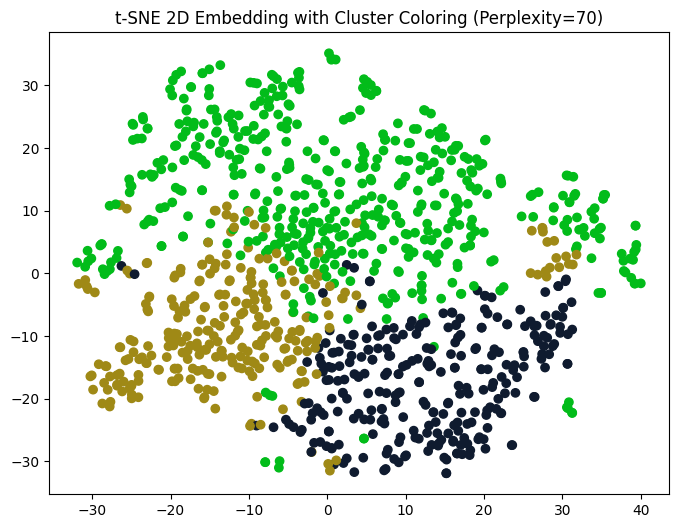

In [17]:
# # print(len(class_0_indices),len(class_1_indices),len(filtered_indices))
all_indices,_ = visualize_and_return_indices(X_embedded_2d, cluster_labels, embeddings_dict,
                                   x1=100,y1=100,x2=None,y2=None,selected_indices=None)



In [18]:

class_0_indices = np.where(cluster_labels == 0)[0]
class_1_indices = np.where(cluster_labels == 1)[0]
class_2_indices = np.where(cluster_labels == 2)[0]
print(0 in cluster_labels[class_1_indices])
print(1 in cluster_labels[class_0_indices])
print(1 in cluster_labels[class_2_indices])
# # 将列表转换为集合，然后求交集
# intersection_set = set(class_0_indices).intersection(class_1_indices)

# intersection_list = list(intersection_set)  # 将交集的集合转换回列表
# print('num',len(class_0_indices),len(class_1_indices))
# print("交集：", intersection_list)

False
False
False


filtered_indices 1092
selected_indices 280
filtered_embeddings.shape (280, 2)


<Figure size 640x480 with 0 Axes>

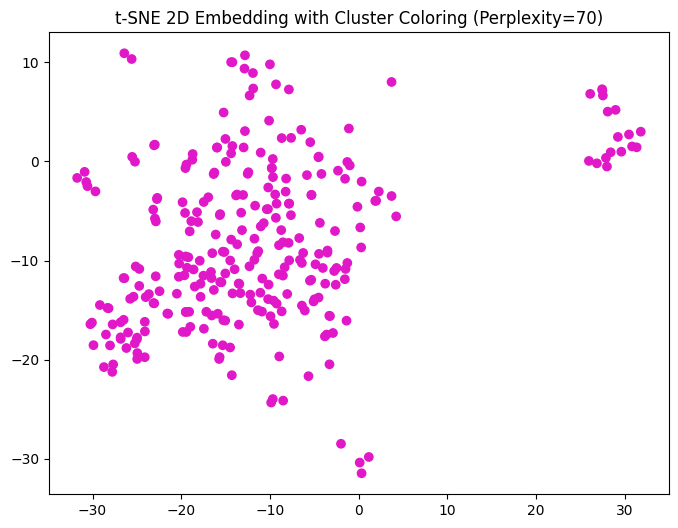

In [19]:
class_0_indices,class_0_names_filtere = visualize_and_return_indices(
    X_embedded_2d, cluster_labels, embeddings_dict,
    selected_indices=class_0_indices)

filtered_indices 1092
selected_indices 529
filtered_embeddings.shape (529, 2)


<Figure size 640x480 with 0 Axes>

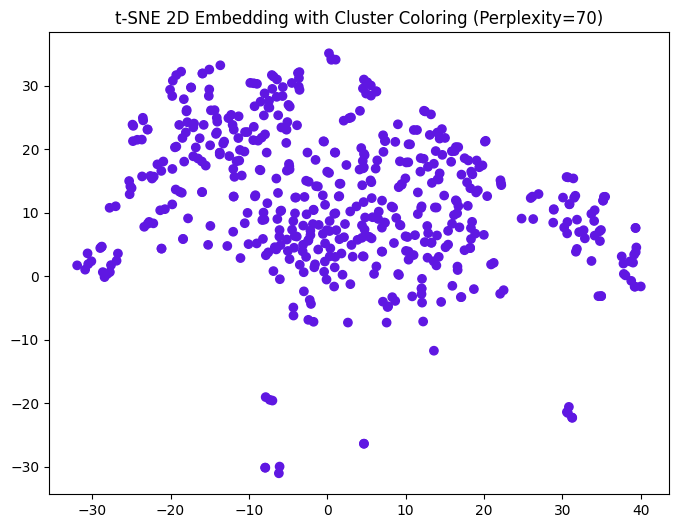

In [26]:
class_1_indices, class1_names_filtered = visualize_and_return_indices(X_embedded_2d, 
                                                                        cluster_labels, embeddings_dict,
                                                                        x1=100,y1=100,x2=None,y2=None,selected_indices=class_1_indices)


filtered_indices 1092
selected_indices 283
filtered_embeddings.shape (283, 2)


<Figure size 640x480 with 0 Axes>

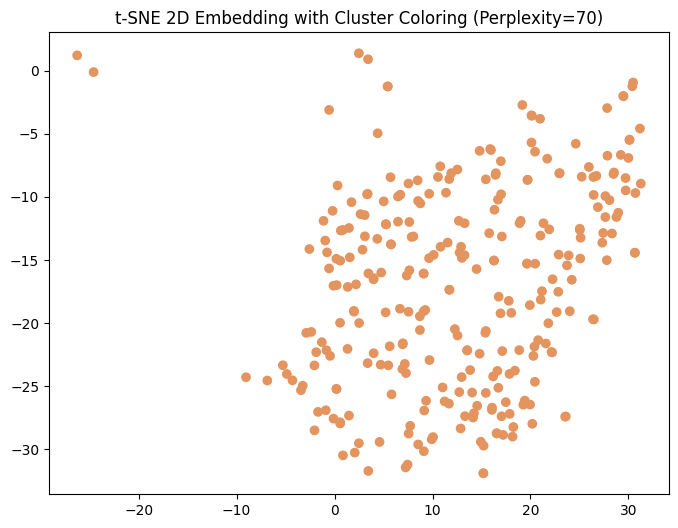

In [27]:
class_2_indices, class2_names_filtered = visualize_and_return_indices(X_embedded_2d, 
                                                                        cluster_labels, embeddings_dict,
                                                                        x1=100,y1=100,x2=None,y2=None,selected_indices=class_2_indices)

### 将所需要的patch从原来的数据集抽取出来

In [22]:
import subprocess
import time
def generate_folder_for_selected(source, #原数据集位置
                                 target, #目的路径
                                 selected_name, #要进行选择的name
                                 num=None): #如果只是想看一部分，而不是选择全部，设置num即可
    address1 = ["/image", "/label"]

    for adr in address1:
        source_path = source+adr
        target_path = target+adr
        os.makedirs(target_path, exist_ok=True)
        if num is None:# 如果 num 未指定，默认为选定名称的长度
            num=len(selected_name)
        for i in range(num):
            print(f"{i/num*100:.2f}%", end="\r")
            time.sleep(0.5)  # 模拟耗时操作
            file_name = selected_name[i]
            source_file = os.path.join(source_path, file_name)
            target_file = os.path.join(target_path, file_name)  
            subprocess.run(['cp', source_file, target_file])## 复制文件到目标路径




In [29]:
source_folder = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091'
target_folder = '/mnt/share102/cs22-wangc/EXACT09/op_Cluster/class1'
generate_folder_for_selected(source_folder, target_folder,class1_names_filtered,)
# class1_names_filtered,names_filtered_end,arc_name,triple_arc_name

In [30]:
source_folder = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091'
target_folder = '/mnt/share102/cs22-wangc/EXACT09/op_Cluster/class0'
generate_folder_for_selected(source_folder, target_folder,class_0_names_filtere)

In [32]:
source_folder = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091'
target_folder = '/mnt/share102/cs22-wangc/EXACT09/op_Cluster/class2'
generate_folder_for_selected(source_folder, target_folder,class2_names_filtered)

In [33]:
source_folder = '/mnt/share102/cs22-wangc/EXACT09/Precrop_dataset_for_EXACT091'
target_folder = '/mnt/share102/cs22-wangc/EXACT09/Cluster/filtered_end'
generate_folder_for_selected(source_folder, target_folder,names_filtered_end,num=600)

In [27]:
def show_all_2d_img_with_labels(raw_img_path, output_folder, img_num=None, 
                                num_images_per_batch=16, slice_index=20, label_path=None):
    """
    将raw_img_path的图像读出，这是一些3d图像，每个图像取slice_index对应位置的2d切片，
    根据下面num_rows = 4，num_cols = 4，将这些切片排列在一张图上，如果label_path不为None，则从对应文件夹读出label图像，进行标注
    """
    raw_img_list = os.listdir(raw_img_path)
    if img_num is None:
        img_num = len(raw_img_list)
    img_num = min(img_num, len(raw_img_list))
    num_batches = (img_num + num_images_per_batch - 1) // num_images_per_batch  # 上取整

    num_rows = 4
    num_cols = 4
    
    # 检查并创建输出文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for batch_num in range(num_batches):
        start_index = batch_num * num_images_per_batch
        end_index = min((batch_num + 1) * num_images_per_batch, img_num)
        
        img_list = []
        for i in range(start_index, end_index):
            raw_img_addr = os.path.join(raw_img_path, raw_img_list[i])
            raw_img = io.imread(raw_img_addr, plugin='simpleitk')
            img_list.append(raw_img)
            print(f'11img_selecting {100 * (i+1) / img_num:.2f}%', end='\r')
        
        # 创建一个包含16个子图的图像窗口
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
        fig.suptitle(f"Batch {batch_num+1} - Raw Images")
        
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                if index < len(img_list):
                    raw_img = img_list[index]
                    ax = axes[i, j]
                    
                    ax.imshow(raw_img[slice_index, :, :], cmap='gray')
                    
                    if label_path is not None:
                        label_img_addr = os.path.join(label_path, raw_img_list[index])
                        label_img = io.imread(label_img_addr, plugin='simpleitk')
                        if 1 not in label_img:
                            ax.text(0.8, 0.9, "No Label", transform=ax.transAxes, color='g', fontsize=12, fontweight='bold')
                        ax.contour(label_img[slice_index, :, :], colors='r', linestyles='-')
                    
                    ax.set_title(f"img_list index {index}")
                    ax.axis('off')
        
        # 调整子图之间的间距和布局
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        
        # 保存图像
        plt.savefig(os.path.join(output_folder, f"output_images_batch_{batch_num+1}.png"))
        
        # 关闭图像窗口，避免重叠
        plt.close()
all_path='/mnt/share102/cs22-wangc/EXACT09/Cluster'
sub_folders = [folder_name for folder_name in os.listdir(all_path) if os.path.isdir(os.path.join(all_path, folder_name))]
sub_folders=['only_right_1','only_right_0',]
for path in sub_folders:
    address1 = ["/image", "/label"]
    raw_img_folder=all_path+'/'+path+address1[0]
    label_path= all_path+'/'+path+address1[1]
    print('this is ',path)
    slice_folder='/home/cs22-wangc/now/slice_folder'+'/'+str(path)

    show_all_2d_img_with_labels(raw_img_folder,slice_folder,img_num=2000,label_path=label_path)

sub_folders

this is  only_right_1
this is  only_right_00%


['only_right_1', 'only_right_0']

In [52]:

def get_label_airway_pixels(label_img, slice_index=None):
    if slice_index is not None:
        if 1 not in label_img[slice_index, :, :]:
            j = 0
            while j < label_img.shape[0] and 1 not in label_img[j, :, :]:
                j += 1
            if j>= label_img.shape[0]:
                j=j-1
            return label_img[j, :, :].sum()
        else:
            return label_img[slice_index, :, :].sum()
    else:
        return label_img.sum()

def analysis_cluster(label_path, slice_index=None):
    label_img_list = os.listdir(label_path)
    pixels_num_list = []
    
    for name in label_img_list:
        label_img_addr = os.path.join(label_path, name)
        label_img = io.imread(label_img_addr, plugin='simpleitk')
        pixels_num = get_airway_pixels(label_img, slice_index)
        pixels_num_list.append(pixels_num)

    # 使用numpy计算均值和方差
    mean_value = np.mean(pixels_num_list)
    std_deviation = np.std(pixels_num_list)
    N = len(pixels_num_list)  # 总体数据点数量
    # total_std_deviation = np.sqrt(np.sum((pixels_num_list - mean_value) ** 2) / N)

    return mean_value, std_deviation#均值和标准差

all_path = "/mnt/wangc/EXACT09/cluster_folder"
sub_folders = [folder_name for folder_name in os.listdir(all_path) if os.path.isdir(os.path.join(all_path, folder_name))]
for sub_name in sub_folders:
    class_num=['class1','class0']
    for i in class_num:
        end_path=all_path+'/'+sub_name+'/'+i+"/label"
        label_img_list=os.listdir(str(end_path))
        a,b=analysis_cluster(label_img_list)
        print(f"{sub_name} 's {class_num} a,b")

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not list